In [2]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [3]:
from torchvision.models import resnet50, ResNet50_Weights

In [4]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
transform_resnet = ResNet50_Weights.DEFAULT.transforms()
# Download the dataset
trainset_resnet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_resnet)
testset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_resnet)
testloader_resnet = torch.utils.data.DataLoader(testset_resnet, batch_size=32, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Split the training dataset into training and validation
size_validset_resnet = 10000
size_trainset_resnet = len(trainset_resnet)-size_validset_resnet
train_set_resnet, valid_set_resnet = random_split(trainset_resnet, [size_trainset_resnet, size_validset_resnet])

trainloader_resnet = torch.utils.data.DataLoader(train_set_resnet, batch_size=32, shuffle=True)
validloader_resnet = torch.utils.data.DataLoader(valid_set_resnet, batch_size=32, shuffle=True)
# now we have training validation and testing 

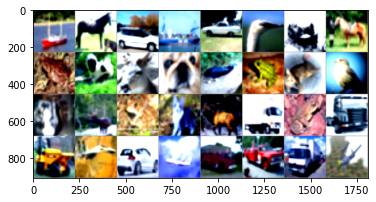

 ship horse   car  ship


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_resnet)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
def train(epochs, model, optimizer):
    train_loss_ls = []
    train_accuracy_ls = []
    val_loss_ls = []
    val_accuracy_ls = []
    model = model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        '''
        This is the training section
        '''
        training_loss = 0
        training_correct = 0
        model.train() # the model is in training mode, will consider evething like batch normalization and dropout
        
        for i, data in enumerate(trainloader_resnet, 0): # each data is one batch
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = outputs.argmax(1)# index of max probability out of 10 classes

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            training_loss += loss.item()
            training_correct += (predicted == labels).sum().item()

        '''
        This is the validation section
        '''
        val_loss = 0
        val_correct = 0
#         val_total = 0
        model.eval()
        with torch.no_grad(): # do not perform any calculation  
            for data in validloader_resnet:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs.argmax(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
#                 val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

#         print('Val Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

        training_loss = training_loss/(len(trainloader_resnet)) # this is consider as batch
        train_acc = (training_correct / len(trainloader_resnet.dataset)) # this consider as all simple
        val_loss = val_loss / len(validloader_resnet)
        val_acc = (val_correct/len(validloader_resnet.dataset))
        
        # save the loss and accuracy in the list
        train_loss_ls.append(training_loss)
        train_accuracy_ls.append(train_acc)
        val_loss_ls.append(val_loss)
        val_accuracy_ls.append(val_acc)
        print("epoch",epoch)
        print("train_accuracy: ",train_acc,"val_accuracy: ",val_acc,"train_loss: ",training_loss, "val_loss:", val_loss)

    print('Finished Training')
    return (train_accuracy_ls,train_loss_ls,val_accuracy_ls,val_loss_ls)

In [19]:
def final_train(epochs, model, optimizer):
    train_loss_ls = []
    train_accuracy_ls = []
    test_loss_ls = []
    test_accuracy_ls = []
    model = model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        '''
        This is the training section
        '''
        training_loss = 0
        training_correct = 0
        model.train() # the model is in training mode, will consider evething like batch normalization and dropout
        
        for i, data in enumerate(trainloader_resnet, 0): # each data is one batch
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = outputs.argmax(1)# index of max probability out of 10 classes

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            training_loss += loss.item()
            training_correct += (predicted == labels).sum().item()

        '''
        This is the test section
        '''
        test_loss = 0
        test_correct = 0
#         val_total = 0
        model.eval()
        with torch.no_grad(): # do not perform any calculation  
            for data in testloader_resnet:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs.argmax(1)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
#                 val_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

#         print('Val Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

        training_loss = training_loss/(len(trainloader_resnet)) # this is consider as batch
        train_acc = (training_correct / len(trainloader_resnet.dataset)) # this consider as all simple
        test_loss = test_loss / len(testloader_resnet)
        test_acc = (test_correct/len(testloader_resnet.dataset))
        
        # save the loss and accuracy in the list
        train_loss_ls.append(training_loss)
        train_accuracy_ls.append(train_acc)
        test_loss_ls.append(test_loss)
        test_accuracy_ls.append(test_acc)
        print("epoch",epoch)
        print("train_accuracy: ",train_acc)
        print("test_accuracy: ",test_acc)

    print('Finished Training')
    return (train_accuracy_ls,train_loss_ls,test_accuracy_ls,test_loss_ls)

In [11]:
# create a function to plot the graph of accuracy and loss 
def plot_graph(train_accuracy_ls,train_loss_ls,val_accuracy_ls,val_loss_ls,epoch):
    # plotting the baseline model
    plt.plot(np.arange(epoch),train_accuracy_ls ,label ="Train accuracy")
    plt.plot(np.arange(epoch),val_accuracy_ls ,label ="Val accuracy")
    plt.plot(np.arange(epoch),train_loss_ls ,label = "train loss")
    plt.plot(np.arange(epoch),val_loss_ls ,label = "val loss")
    plt.title("Training accuracy and loss")
    plt.xlabel("Number of epoch")
    plt.legend()
    plt.show()

In [16]:
# create a function to plot the graph of accuracy and loss 
def plot_graph_final(train_accuracy_ls,test_accuracy_ls,epoch):
    # plotting the baseline model
    plt.plot(np.arange(epoch),train_accuracy_ls ,label ="train accuracy")
    plt.plot(np.arange(epoch),test_accuracy_ls ,label ="test accuracy")
    plt.title("Test accuracy of best ResNet 50 model")
    plt.xlabel("Number of epoch")
    plt.legend()
    plt.show()

In [12]:
resnet_model_one = resnet50(weights = ResNet50_Weights.DEFAULT, progress=True)
resnet_model_one.fc = nn.Linear(2048,10)
print(resnet_model_one)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# resnet50, SGD, 0.001, 5 epochs, momentum = 0.9
optimizer_resnet_one = optim.SGD(resnet_model_one.parameters(), lr=0.001,momentum = 0.9)
results_resnet_one = train(5, resnet_model_one, optimizer_resnet_one)

epoch 0
train_accuracy:  0.83685 val_accuracy:  0.9394 train_loss:  0.5405574830144644 val_loss: 0.1808481380557671
epoch 1
train_accuracy:  0.94855 val_accuracy:  0.9593 train_loss:  0.15858538323268295 val_loss: 0.12418458003925677
epoch 2
train_accuracy:  0.9711 val_accuracy:  0.9599 train_loss:  0.08842144324742257 val_loss: 0.11495653499206439
epoch 3
train_accuracy:  0.982825 val_accuracy:  0.9643 train_loss:  0.054887609869986774 val_loss: 0.10948371780127251
epoch 4
train_accuracy:  0.98935 val_accuracy:  0.9629 train_loss:  0.03639146714983508 val_loss: 0.11113399218938227
Finished Training


In [14]:
# resnet50, SGD, 0.0001, 5 epochs
resnet_model_two = resnet50(weights = ResNet50_Weights.DEFAULT, progress=True)
resnet_model_two.fc = nn.Linear(2048,10)
optimizer_resnet_two = optim.SGD(resnet_model_two.parameters(), lr=0.0001, momentum=0.9)
results_resnet_two = train(5, resnet_model_two, optimizer_resnet_two)

epoch 0
train_accuracy:  0.52565 val_accuracy:  0.7445 train_loss:  1.7971496364593507 val_loss: 1.1747644366547703
epoch 1
train_accuracy:  0.79615 val_accuracy:  0.8571 train_loss:  0.8009860038995743 val_loss: 0.5092396335289501
epoch 2
train_accuracy:  0.86535 val_accuracy:  0.8932 train_loss:  0.44739053446650506 val_loss: 0.34657980415958184
epoch 3
train_accuracy:  0.896175 val_accuracy:  0.9174 train_loss:  0.32681274797618387 val_loss: 0.2635474507205974
epoch 4
train_accuracy:  0.913875 val_accuracy:  0.926 train_loss:  0.26750157031416893 val_loss: 0.2227907174478133
Finished Training


In [16]:
# resnet50, Adam, 0.001, 5 epochs
resnet_model_three = resnet50(weights = ResNet50_Weights.DEFAULT, progress=True)
resnet_model_three.fc = nn.Linear(2048,10)
optimizer_resnet_three = optim.Adam(resnet_model_three.parameters(), lr=0.001)
results_resnet_three = train(5, resnet_model_three, optimizer_resnet_three)

epoch 0
train_accuracy:  0.771375 val_accuracy:  0.829 train_loss:  0.6654627066671849 val_loss: 0.502020396363621
epoch 1
train_accuracy:  0.868675 val_accuracy:  0.8609 train_loss:  0.38495265492200853 val_loss: 0.4041321213348224
epoch 2
train_accuracy:  0.901275 val_accuracy:  0.8873 train_loss:  0.2851828290790319 val_loss: 0.33823223428699534
epoch 3
train_accuracy:  0.9253 val_accuracy:  0.8855 train_loss:  0.21488786993548273 val_loss: 0.35491591397399147
epoch 4
train_accuracy:  0.941075 val_accuracy:  0.8931 train_loss:  0.1661896563999355 val_loss: 0.3256062979634387
Finished Training


In [17]:
# resnet50, Adam, 0.0001, 5 epochs
resnet_model_four = resnet50(weights = ResNet50_Weights.DEFAULT, progress=True)
resnet_model_four.fc = nn.Linear(2048,10)
optimizer_resnet_four = optim.Adam(resnet_model_four.parameters(), lr=0.0001)
results_resnet_four = train(5, resnet_model_four, optimizer_resnet_four)

epoch 0
train_accuracy:  0.878775 val_accuracy:  0.9463 train_loss:  0.3826616613939404 val_loss: 0.1634145572531623
epoch 1
train_accuracy:  0.9608 val_accuracy:  0.9511 train_loss:  0.12146330370791257 val_loss: 0.14525446896485913
epoch 2
train_accuracy:  0.9763 val_accuracy:  0.9506 train_loss:  0.07077900181859732 val_loss: 0.15467241063368872
epoch 3
train_accuracy:  0.98215 val_accuracy:  0.9541 train_loss:  0.055868868751171974 val_loss: 0.15140438991592833
epoch 4
train_accuracy:  0.984875 val_accuracy:  0.9481 train_loss:  0.04576447766562924 val_loss: 0.17041980356280023
Finished Training


In [20]:
# test the best model which is --> resnet50, SGD, 0.001, 5 epochs, momentum = 0.9
final_resnet = resnet50(weights = ResNet50_Weights.DEFAULT, progress=True)
final_resnet.fc = nn.Linear(2048,10)
final_optimizer_resnet= optim.SGD(final_resnet.parameters(), lr=0.001,momentum = 0.9)
final_results_resnet = final_train(5, final_resnet, final_optimizer_resnet)

epoch 0
train_accuracy:  0.829375
test_accuracy:  0.9426
epoch 1
train_accuracy:  0.947475
test_accuracy:  0.9556
epoch 2
train_accuracy:  0.971975
test_accuracy:  0.9606
epoch 3
train_accuracy:  0.9847
test_accuracy:  0.9625
epoch 4
train_accuracy:  0.99025
test_accuracy:  0.964
Finished Training


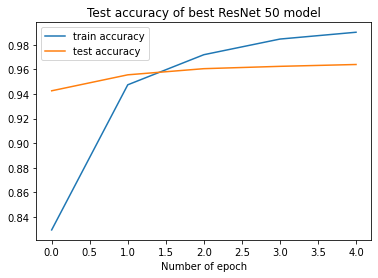

In [21]:
plot_graph_final(final_results_resnet[0],final_results_resnet[2],5)